In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gseapy as gp
from tqdm import tqdm
from adjustText import adjust_text
import seaborn as sns
import anndata
from scipy.spatial import distance
import itertools
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

In [2]:
def cells_within_radius(adata,cell_type_col,target_cell, radius=10):
    """
    Find all cells within a given radius (in microns) of Granule cells in a spatial seq anndata object.

    Parameters:
    adata : AnnData
        Annotated data matrix.
    radius : float
        Radius in microns to search for neighboring cells. Default is 10 microns.

    Returns:
    pd.DataFrame
        DataFrame with indices of cells within the given radius of Granule cells.
    """
    new_adata = adata.copy()
    new_adata.obs.set_index('Name', inplace=True)
    # Extract coordinates and batch IDs
    x_coords = new_adata.obs['x'].values
    y_coords = new_adata.obs['y'].values
    batch_ids = new_adata.obs['batchID'].values
    cell_types = new_adata.obs[cell_type_col]
    
    new_adata.obs[f"peri_{target_cell}"] = False

    granule_indices = np.where(cell_types == target_cell)[0]

    results = []

    # Iterate through each Granule cell and find neighboring cells
    for granule_idx in tqdm(granule_indices, desc="Processing Peri Granule Cells"):
        granule_x = x_coords[granule_idx]
        granule_y = y_coords[granule_idx]
        granule_batch = batch_ids[granule_idx]

        # Calculate distances to all other cells in the same batch
        same_batch_indices = np.where(batch_ids == granule_batch)[0]
        same_batch_x = x_coords[same_batch_indices]
        same_batch_y = y_coords[same_batch_indices]

        distances = np.sqrt((same_batch_x - granule_x)**2 + (same_batch_y - granule_y)**2)

        within_radius_indices = same_batch_indices[np.where(distances <= radius)[0]]

        new_adata.obs.iloc[within_radius_indices, new_adata.obs.columns.get_loc(f"peri_{target_cell}")] = True

    return new_adata


def shift_log_normalized(adata):
    """
    Shift log-normalized values to be non-negative.
    
    Parameters:
    adata : AnnData
        Annotated data matrix.
    
    Returns:
    AnnData
        AnnData object with shifted log-normalized values.
    """
    adata_copy = adata.copy()
    min_val = adata_copy.X.min()
    if min_val < 0:
        adata_copy.X = adata_copy.X - min_val
    return adata_copy

def differential_expression(adata1, adata2, shift_log_values=False):
    """
    Perform differential expression analysis between two AnnData objects.

    Parameters:
    adata1 : AnnData
        First annotated data matrix.
    adata2 : AnnData
        Second annotated data matrix.
    shift_log_values : bool
        Whether to shift log-normalized values to be non-negative.

    Returns:
    pd.DataFrame
        DataFrame containing differential expression results.
    """
    # Add a column indicating the origin of each cell
    adata1.obs['group'] = 'group1'
    adata2.obs['group'] = 'group2'

    if shift_log_values:
        adata1 = shift_log_normalized(adata1)
        adata2 = shift_log_normalized(adata2)

    # Concatenate the two AnnData objects
    adata_combined = adata1.concatenate(adata2, batch_key='batch', batch_categories=['group1', 'group2'])

    # Perform differential expression analysis using Scanpy
    sc.tl.rank_genes_groups(adata_combined, groupby='batch', reference='group1', method='wilcoxon')

    # Extract results into a DataFrame
    results = adata_combined.uns['rank_genes_groups']
    groups = results['names'].dtype.names
    pvals = pd.DataFrame({group + '_pvals': results['pvals'][group] for group in groups})
    pvals_adj = pd.DataFrame({group + '_pvals_adj': results['pvals_adj'][group] for group in groups})
    logfoldchanges = pd.DataFrame({group + '_logfoldchanges': results['logfoldchanges'][group] for group in groups})
    names = pd.DataFrame({group + '_names': results['names'][group] for group in groups})

    return pd.concat([names, pvals, pvals_adj, logfoldchanges], axis=1)

def plot_volcano(
    df, 
    sig_lfc=0.5, 
    group='group2', 
    pval_col_suffix='_pvals', 
    logfc_col_suffix='_logfoldchanges', 
    name_col_suffix='_names', 
    title='Volcano Plot', 
    xlims=None, 
    savefig=None
):
    """
    Plot a volcano plot for differential expression analysis results.

    Parameters:
    df : pd.DataFrame
        DataFrame containing differential expression results.
    group : str
        Group name for differential expression results.
    pval_col_suffix : str
        Suffix for the p-value column in the DataFrame.
    logfc_col_suffix : str
        Suffix for the log fold change column in the DataFrame.
    name_col_suffix : str
        Suffix for the gene names column in the DataFrame.
    title : str
        Title for the plot.
    xlims : tuple, optional
        Limits for the x-axis.
    savefig : str, optional
        Path to save the figure.

    Returns:
    list, list
        Two lists containing significant genes with log fold change < 1 and > 1.
    """
    pvals = df[group + pval_col_suffix]
    logfoldchanges = df[group + logfc_col_suffix]
    gene_names = df[group + name_col_suffix]
    
    # Define significance thresholds
    sig_pval = 0.05
    sig_logfc = sig_lfc
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.scatter(logfoldchanges, -np.log10(pvals), color='grey', alpha=0.5, label='NS')
    
    # Highlight significant points
    sig_points = (pvals < sig_pval) & (np.abs(logfoldchanges) > sig_logfc)
    plt.scatter(logfoldchanges[sig_points], -np.log10(pvals[sig_points]), color='red', alpha=0.50, label='P-value and log2 FC')
    plt.scatter(logfoldchanges[(pvals < sig_pval) & ~sig_points], -np.log10(pvals[(pvals < sig_pval) & ~sig_points]), color='blue', alpha=0.50, label='P-value')
    plt.scatter(logfoldchanges[~(pvals < sig_pval) & (np.abs(logfoldchanges) > sig_logfc)], -np.log10(pvals[~(pvals < sig_pval) & (np.abs(logfoldchanges) > sig_logfc)]), color='green', alpha=0.50, label='Log2 FC')
    
    plt.axhline(y=-np.log10(sig_pval), color='black', linestyle='--')
    plt.axvline(x=sig_logfc, color='black', linestyle='--')
    plt.axvline(x=-sig_logfc, color='black', linestyle='--')
    
    # Annotate significant genes
    texts = []
    sig_genes_less_than_1 = []  # List for significant genes with logFC < 1
    sig_genes_greater_than_1 = []  # List for significant genes with logFC > 1

    for i in range(len(gene_names)):
        if sig_points[i]:
            if logfoldchanges[i] < -1*sig_lfc:
                sig_genes_less_than_1.append(gene_names[i])
            elif logfoldchanges[i] > sig_lfc:
                sig_genes_greater_than_1.append(gene_names[i])

            texts.append(plt.text(logfoldchanges[i], -np.log10(pvals[i]), gene_names[i], fontsize=8))
    
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'))
    
    plt.xlabel('Log2 fold change')
    plt.ylabel('-Log10 P-value')
    plt.title(title)
    plt.legend(loc='best')
    
    if xlims is not None:
        plt.xlim(xlims)
        
    if savefig is not None:
        plt.savefig(savefig, format='pdf')
        
    plt.show()
    
    return sig_genes_less_than_1, sig_genes_greater_than_1

def add_activated_microglia_column(adata, cell_type_col='updated_celltype', cd9_threshold=9):
    """
    Add a column 'activated_microglia' to the AnnData object to mark activated microglia cells.
    
    Parameters:
    adata : AnnData
        Annotated data matrix.
    cell_type_col : str
        Column name in adata.obs that contains the cell type information.
    trem2_threshold : float
        Expression threshold for Trem2.
    cd9_threshold : float
        Expression threshold for Cd9.
    
    Returns:
    AnnData
        AnnData object with an added 'activated_microglia' column in adata.obs.
    """
    # Ensure Trem2 and Cd9 are in the var_names
    if 'Trem2' not in adata.var_names or 'Cd9' not in adata.var_names:
        raise ValueError("Trem2 and/or Cd9 are not present in the var_names of the AnnData object.")
    
    # Initialize the 'activated_microglia' column with False
    adata.obs['activated_microglia'] = False

    # Check conditions and update the 'activated_microglia' column
    microglia_mask = adata.obs[cell_type_col] == 'Microglia'
    #trem2_expression = adata[:, 'Trem2'].X > trem2_threshold
    cd9_expression = adata[:, 'Cd9'].X > cd9_threshold

    activated_mask = microglia_mask & cd9_expression.flatten()# & trem2_expression.flatten()
    adata.obs.loc[activated_mask, 'activated_microglia'] = True

    return adata

def label_microglia_layers(ad, cell_type_col='updated_celltype', region_col='Brain_Region', 
                           granule_cell_type='Granule cells', purkinje_cell_type='Purkinje cells', 
                           microglia_cell_type='Microglia NN', batch_col = 'batchID', distance_threshold=5):
    """
    Labels microglia in the cerebellum based on their proximity to Purkinje cells and Granule cells.
    The function adds a new column 'Cerebellum_layer' to adata.obs with the values:
    'Molecular layer', 'Granule layer', or 'White matter'.
    
    Parameters:
    adata : AnnData
        Annotated data matrix.
    cell_type_col : str
        Column name in adata.obs that contains the cell type information.
    region_col : str
        Column name in adata.obs that contains the region information.
    granule_cell_type : str
        Name of the Granule cell type in the cell_type_col.
    purkinje_cell_type : str
        Name of the Purkinje cell type in the cell_type_col.
    microglia_cell_type : str
        Name of the Microglia cell type in the cell_type_col.
    distance_threshold : float
        Distance threshold (in microns) to define proximity to Granule cells for the Granule layer.
    
    Returns:
    AnnData
        AnnData object with an added 'Cerebellum_layer' column in adata.obs.
    """
    
    ad.obs['Cerebellum_layer'] = 'White matter'

    # Iterate over each unique batchID
    for batch_id in ad.obs[batch_col].unique():
        print(batch_id)
        # Subset the data for the current batch
        batch_mask = ad.obs[batch_col] == batch_id
        batch_data = ad[batch_mask]

        # Identify Microglia within the current batch and cerebellum
        microglia_mask = (batch_data.obs['subclass_label_transfer'] == microglia_cell_type) & (batch_data.obs[region_col] == 'Cerebellum')
        # Get coordinates of Granule and Purkinje cells within the current batch
        granule_coords = batch_data[batch_data.obs[cell_type_col] == granule_cell_type].obs[['x', 'y']].values
        purkinje_coords = batch_data[batch_data.obs[cell_type_col] == purkinje_cell_type].obs[['x', 'y']].values

        # Get coordinates of Microglia within the current batch
        microglia_coords = batch_data[microglia_mask].obs[['x', 'y']].values

        # Skip calculation if granule_coords or purkinje_coords is empty
        if len(granule_coords) == 0 or len(purkinje_coords) == 0 or len(microglia_coords) == 0:
            continue

        # Calculate distances from Microglia to Granule and Purkinje cells
        distances_to_granule = np.min(distance.cdist(microglia_coords, granule_coords), axis=1)
        distances_to_purkinje = np.min(distance.cdist(microglia_coords, purkinje_coords), axis=1)

        # Determine if Microglia are within the Granule layer
        granule_layer_mask = distances_to_granule <= distance_threshold
        batch_data.obs.loc[microglia_mask, 'Cerebellum_layer'] = np.where(granule_layer_mask, 'Granule layer', 'White matter')

        # Determine if Microglia are closer to Purkinje cells than Granule cells (Molecular layer)
        molecular_layer_mask = distances_to_purkinje < distances_to_granule

        # Apply the molecular layer mask only to the subset of microglia
        microglia_indices = batch_data.obs.index[microglia_mask]
        batch_data.obs.loc[microglia_indices[molecular_layer_mask & ~granule_layer_mask], 'Cerebellum_layer'] = 'Molecular layer'

        # Update the original adata with the modified batch_data
        ad.obs.loc[batch_mask, 'Cerebellum_layer'] = batch_data.obs['Cerebellum_layer']

    return ad

In [3]:
adata = sc.read_h5ad('ABC_cleaned.h5ad')
adata_HQ = adata[adata.obs.subclass_label_confidence > 0.8]

adata_HQ.X = adata_HQ.layers['counts'].toarray().copy()
sc.pp.normalize_total(adata_HQ)
sc.pp.log1p(adata_HQ)

adata_cer_regions = label_microglia_layers(adata_HQ, distance_threshold=30)

/oak/stanford/groups/quake/doug/resources/miniconda3/envs/Vizgen_2/lib/python3.9/site-packages/anndata/_core/anndata.py:618: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/oak/stanford/groups/quake/doug/resources/miniconda3/envs/Vizgen_2/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


3-mo-female-2
24-mo-female-1
24-mo-female-3
24-mo-female-5
24-mo-male-1
24-mo-male-2
24-mo-male-4-rev2
3-mo-male-1
3-mo-male-2
3-mo-male-3-rev2
3-mo-female-1-rev2
3-mo-female-3


In [4]:
adata_cer_regions = adata_cer_regions[(adata_cer_regions.obs.subclass_label_transfer == 'Microglia NN') & (adata_cer_regions.obs.Brain_Region == 'Cerebellum')]
granules = adata_HQ[adata_HQ.obs.updated_celltype == 'Granule cells']

/oak/stanford/groups/quake/doug/resources/miniconda3/envs/Vizgen_2/lib/python3.9/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


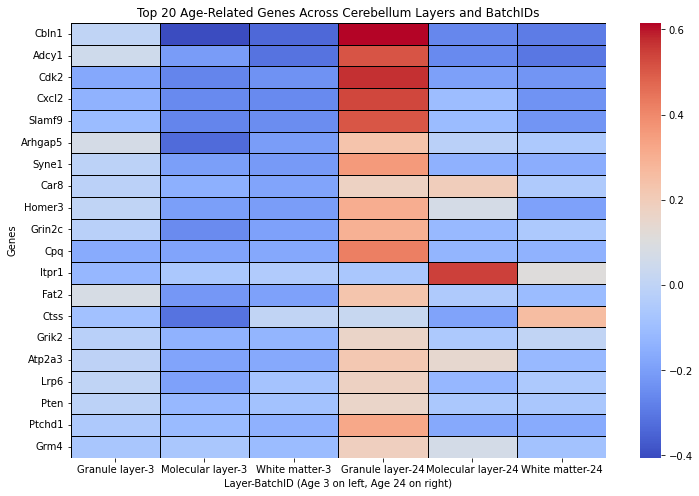

In [5]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# top 20 aging genes
sc.tl.rank_genes_groups(adata_cer_regions, groupby='Age', method='wilcoxon', n_genes=20)
top_genes = adata_cer_regions.uns['rank_genes_groups']['names']['24'][:20]

# scale the values
adata_raw = adata_cer_regions[:, top_genes].copy()  # Subset to top genes
sc.pp.scale(adata_raw)  # Z-score normalization

#Organize data by layer-batchID pairs and split by age
adata_raw.obs['layer_batchID'] = adata_raw.obs['Cerebellum_layer'].astype(str) + '-' + adata_raw.obs['Age'].astype(str)

# Create a matrix for the heatmap
heatmap_data = []
for age in ['3', '24']:
    age_data = adata_raw[adata_raw.obs['Age'] == age]
    matrix = pd.DataFrame(age_data.X, columns=top_genes, index=age_data.obs['layer_batchID'])
    matrix = matrix.groupby(matrix.index).mean()  # Average values for each layer-batchID pair
    heatmap_data.append(matrix.T)  # Transpose to have genes as rows

# Combine the matrices for the heatmap
heatmap_df = pd.concat(heatmap_data, axis=1)

#Generate the heatmap
fig = plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_df, 
    cmap='coolwarm', 
    yticklabels=True, 
    xticklabels=True, 
    linewidths=0.5,  # Adjust this value to control the thickness of the grid lines
    linecolor='black'  # Set the color of the grid lines
)
plt.title("Top 20 Age-Related Genes Across Cerebellum Layers and BatchIDs")
plt.xlabel("Layer-BatchID (Age 3 on left, Age 24 on right)")
plt.ylabel("Genes")
fig.savefig('figures/heatmap_microglia_region.pdf', format='pdf')
plt.show()

In [6]:
import scanpy as sc
import pandas as pd
from typing import Dict, Optional

def de_layers(
    adata,
    layer_col: str = "Cerebellum_layer",
    method: str = "wilcoxon",
    n_genes: Optional[int] = None,
) -> Dict[str, pd.DataFrame]:
    """
    Differential expression for each cerebellar layer (“one”) vs all other layers (“rest”),
    pooling cells across every age.

    Parameters
    ----------
    adata : AnnData
        Single-cell object with `layer_col` in `.obs`.
    layer_col : str, default "Cerebellum_layer"
        Column that defines cerebellar layers.
    method : str, default "wilcoxon"
        Test used by `sc.tl.rank_genes_groups`.
    n_genes : int or None
        Maximum number of genes to keep for each layer (`None` keeps all).

    Returns
    -------
    dict[layer] → pandas.DataFrame
        One DataFrame per layer with columns: gene names, scores, logfoldchanges,
        pvals, pvals_adj, etc.
    """
    ad_tmp = adata.copy()
    sc.tl.rank_genes_groups(
        ad_tmp,
        groupby=layer_col,
        method=method,
        use_raw=False,
        n_genes=n_genes,
    )

    return {
        layer: sc.get.rank_genes_groups_df(ad_tmp, group=layer)
        for layer in ad_tmp.obs[layer_col].unique()
    }

In [7]:
layer_de_all = de_layers(adata_cer_regions)

# Show the first five genes for the Molecular layer
print(layer_de_all["Molecular layer"].head())

# Optional: save each table
for layer, df in layer_de_all.items():
    df.to_csv(f"DE_{layer.replace(' ', '_')}_vs_rest_all_ages.csv", index=False)

   names    scores  logfoldchanges         pvals     pvals_adj
0   Gad1  9.281859        1.626500  1.665467e-20  8.060862e-18
1  Pvalb  8.911231        1.293381  5.046891e-19  1.221348e-16
2  Gria2  6.979157        1.064101  2.969564e-12  4.790897e-10
3   Ntn1  6.039214        1.272442  1.548665e-09  1.499108e-07
4  Itpr1  4.998412        0.651370  5.780447e-07  4.662894e-05


In [8]:
layer_de_all["Granule layer"][(layer_de_all["Granule layer"].pvals_adj < 0.05) & 
                              (layer_de_all["Granule layer"].logfoldchanges > 0.5)].names.tolist()

['Cbln1',
 'Adcy1',
 'Cdk2',
 'Cxcl2',
 'Syne1',
 'Slamf9',
 'Arhgap5',
 'Homer3',
 'Fat2',
 'Grin2c',
 'Lrp6',
 'Igf1r',
 'Sdc3',
 'Pten',
 'Cpq',
 'Atp2a3',
 'Sv2c',
 'Car8',
 'Ptchd1',
 'Acvr1',
 'Utp14b',
 'Grin2a',
 'Pdcd1lg2']

In [9]:
# Module scoring of granule aging genes
#scale the data first
sc.pp.scale(adata_cer_regions,max_value=10)

# non-granule cells genes from heat map - Granule influence genes
#interest = ['Adcy1', 'Cxcl2', 'Grin2a', 'Slamf9', 'Ptchd1', 'Syne1', 'Sv2c', 'Acvr1','Cdk2']
interest = ['Cxcl2','Slamf9','Cdk2', 'Atp2a3', 'Arhgap5']


sc.tl.score_genes(adata_cer_regions,gene_list=interest,score_name='interest')

In [10]:
def plot_barplot_by_age_region(adata, score_name, output_pdf_path=None):
    """
    Plot a boxplot of the score split by age and hue'd by region.
    
    Parameters:
    - adata: AnnData object containing the data
    - score_name: The name of the score to be plotted (must be present in adata.obs)
    
    Returns:
    - A boxplot split by 'Age' and hue'd by 'Region'
    """
    # Ensure the score is in adata.obs
    if score_name not in adata.obs.columns:
        raise ValueError(f"{score_name} not found in adata.obs columns.")
    
    # Create a DataFrame from adata.obs with relevant columns
    plot_data = adata.obs[['Age', 'Cerebellum_layer', score_name]].copy()
    
    # Plot the boxplot using seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(data=plot_data, x='Age', y=score_name, hue='Cerebellum_layer',errorbar="se", capsize=0.1)
    
    # Customize plot labels and title
    plt.title(f'Boxplot of {score_name} split by Age and Cerebellum_layer')
    plt.xlabel('Age')
    plt.ylabel(f'{score_name} Score')
    plt.legend(title='Cerebellum_layer')
    
    if output_pdf_path:
        plt.savefig(output_pdf_path, format='pdf')
        print(f"Plot saved to {output_pdf_path}")
    
    # Show the plot
    plt.show()

Plot saved to figures/aging_granule_microglia.pdf


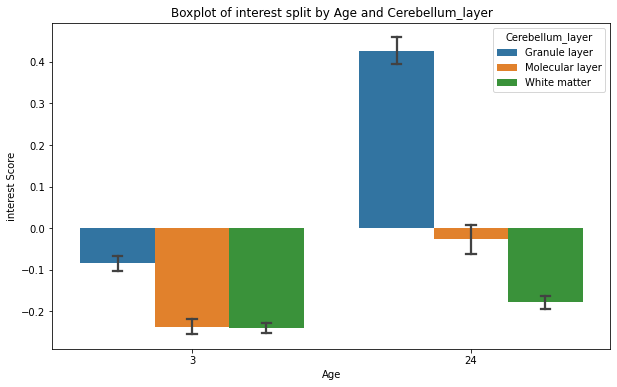

In [11]:
plot_barplot_by_age_region(adata_cer_regions, 'interest',output_pdf_path='figures/aging_granule_microglia.pdf')

In [12]:
# Do it across the whole brain

In [13]:
def plot_boxplot_by_age_region(adata, score_name, output_pdf_path=None, output_stats_csv=None):
    """
    Plot a boxplot of the score split by age and hue'd by region, and optionally save it to a PDF.
    Also computes pairwise Mann-Whitney U tests between all the columns, FDR-corrected.
    
    Parameters:
    - adata: AnnData object containing the data.
    - score_name: The name of the score to be plotted (must be present in adata.obs).
    - output_pdf_path: Optional. If provided, the plot will be saved to this path as a PDF.
    - output_stats_csv: Optional. If provided, the Mann-Whitney U test results will be saved to this path as a CSV.
    
    Returns:
    - A boxplot split by 'Age' and hue'd by 'Region', displayed on screen or saved as a PDF.
    - A DataFrame containing pairwise Mann-Whitney U test results with FDR correction.
    """
    # Ensure the score is in adata.obs
    if score_name not in adata.obs.columns:
        raise ValueError(f"{score_name} not found in adata.obs columns.")
    
    # Create a DataFrame from adata.obs with relevant columns
    plot_data = adata.obs[['Age', 'Brain_Region', score_name]].copy()
    
    # Plot the barplot using seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(data=plot_data, x='Age', y=score_name, hue='Brain_Region', errorbar='se', capsize=0.1)
    
    # Customize plot labels and title
    plt.title(f'Barplot of {score_name} split by Age and Region')
    plt.xlabel('Age')
    plt.ylabel(f'{score_name} Score')
    plt.legend(title='Brain_Region')
    
    # Check if output_pdf_path is provided; if so, save the plot to the PDF
    if output_pdf_path:
        plt.savefig(output_pdf_path, format='pdf')
        print(f"Plot saved to {output_pdf_path}")
    
    # Show the plot
    plt.show()
    plt.close()  # Close the plot to avoid memory issues if used in a loop or script
    
    # Prepare data for pairwise Mann-Whitney U tests
    pairwise_comparisons = []
    unique_groups = plot_data.groupby(['Age', 'Brain_Region'])[score_name]
    
    # Get all possible pairs for comparison
    group_pairs = list(itertools.combinations(unique_groups.groups.keys(), 2))
    
    # Perform Mann-Whitney U test for each pair
    for (age1, region1), (age2, region2) in group_pairs:
        group1 = unique_groups.get_group((age1, region1))
        group2 = unique_groups.get_group((age2, region2))
        
        # Only perform the test if both groups have more than one sample
        if len(group1) > 1 and len(group2) > 1:
            stat, pval = mannwhitneyu(group1, group2, alternative='two-sided')
        else:
            pval = 1  # Assign a high p-value if not enough data
        
        pairwise_comparisons.append({
            'Group1': f"{age1}_{region1}",
            'Group2': f"{age2}_{region2}",
            'pval': pval
        })
    
    # Convert to DataFrame
    stats_df = pd.DataFrame(pairwise_comparisons)
    
    # Apply FDR correction
    stats_df['pval_adj'] = multipletests(stats_df['pval'], method='fdr_bh')[1]
    
    # Optionally save the statistics to a CSV
    if output_stats_csv:
        stats_df.to_csv(output_stats_csv, index=False)
        print(f"Statistics saved to {output_stats_csv}")
    
    return stats_df

/oak/stanford/groups/quake/doug/resources/miniconda3/envs/Vizgen_2/lib/python3.9/site-packages/anndata/_core/anndata.py:618: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/oak/stanford/groups/quake/doug/resources/miniconda3/envs/Vizgen_2/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/oak/stanford/groups/quake/doug/resources/miniconda3/envs/Vizgen_2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:169: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


Plot saved to figures/MERFISH_score_barplot.pdf


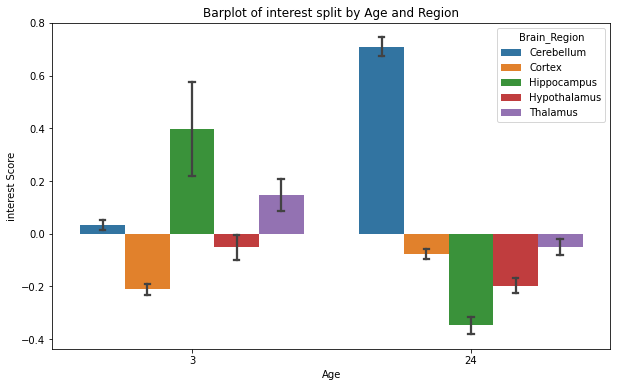

/tmp/ipykernel_12432/3225837975.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  unique_groups = plot_data.groupby(['Age', 'Brain_Region'])[score_name]


In [14]:
adata = sc.read_h5ad('ABC_cleaned.h5ad')
adata_HQ = adata[adata.obs.subclass_label_confidence > 0.5]

adata_HQ.X = adata_HQ.layers['counts'].copy()
sc.pp.normalize_total(adata_HQ, target_sum=1e4)
sc.pp.log1p(adata_HQ)
#scale values because scoring
sc.pp.scale(adata_HQ,max_value=10)

interest = ['Cxcl2','Slamf9','Cdk2', 'Atp2a3', 'Arhgap5']
mic = adata_HQ[(adata_HQ.obs.subclass_label_transfer == 'Microglia NN') & (adata_HQ.obs.Brain_Region.isin(['Cerebellum','Cortex','Hippocampus','Hypothalamus','Thalamus']))]
#sc.pp.scale(mic,max_value=10)
sc.tl.score_genes(mic,gene_list=interest,score_name='interest')
test = plot_boxplot_by_age_region(mic,'interest',output_pdf_path='figures/MERFISH_score_barplot.pdf')